# Experiment 1: 2D Invariant Matern-5/2 GP

## Target function

First, define the target function, which in this case is generated by drawing from a GP with permutation invariant Matern 5/2 kernel (see [`kernel_objective_function.jl`](kernel_objective_function.jl)).

Precompiling Plots
  ✓ Plots
  1 dependency successfully precompiled in 46 seconds. 158 already precompiled.
Precompiling IJuliaExt
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → GeometryBasicsExt
  ✓ Plots → IJuliaExt
  4 dependencies successfully precompiled in 9 seconds. 188 already precompiled.


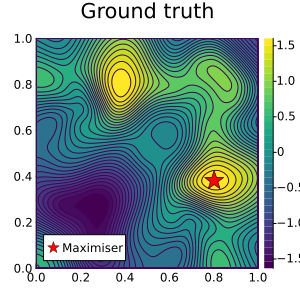

In [1]:
using Plots
include("gp_utils.jl")
include("invariant_gps.jl")
include("kernel_objective_function.jl")

# Define the function
d = 2
bounds = [(0.0, 1.0) for i in 1:d]
θ_true = (
    l=0.2,
    σ_f=1.0,
    σ_n=0.1,
)
latent_function_seed = 22 # Play around with this to get different functions 
n_points = 64
f = build_latent_function(build_permutationinvariantmatern52_gp, θ_true, n_points, bounds, latent_function_seed)

# Get the max f on the grid
xi_range = range(0.0, 1.0, length=100)
x_eval = vec([[xi, xj] for xi in xi_range, xj in xi_range])
y_eval = vec([f([xi, xj]) for xi in xi_range, xj in xi_range])
y_eval_max, maximiser_index = findmax(y_eval)
maximiser = x_eval[maximiser_index]

# Fine-tune with BFGS 
x0 = [
    bounded(maximiser[1], bounds[1][1], bounds[1][2]),
    bounded(maximiser[2], bounds[2][1], bounds[2][2]),
]
x0_flat, unflatten = value_flatten(x0)
result = optimize(x -> -f(unflatten(x)), x0_flat, BFGS(), Optim.Options(iterations=1000))
x_opt = unflatten(Optim.minimizer(result))
y_opt = f(x_opt)

# Visualise
contourf(xi_range, xi_range, (x, y) -> f([x, y]), levels=32, color=:viridis, cbar=true, size=(300, 300), title="Ground truth")
plot!([x_opt[1]], [x_opt[2]], marker=:star, markersize=10, color=:red, label="Maximiser", legend=:bottomleft, xlims=(0.0, 1.0), ylims=(0.0, 1.0), seriestype=:scatter)

## Bayesian optimisation 

Now, perform BO with the invariant and non-invariant kernels:

In [12]:
using HDF5
include("bayesopt.jl")

n_repeats = 4
n_iterations = 64
β = 5.5
acquisition_function = (posterior_gp, x) -> ucb(posterior_gp, x; β=β)
label = "ucb_β=$β"

# Create the file 
filename = "$(label)_results.h5"
h5open(filename, "cw") do file
    # Save metadata
    attrs(file)["n_repeats"] = n_repeats
    attrs(file)["n_iterations"] = n_iterations
    attrs(file)["acquisition_function"] = label
    attrs(file)["objective_function"] = "kernel_objective_function"
    attrs(file)["objective_function_seed"] = latent_function_seed
    attrs(file)["objective_function_bounds"] = bounds
    attrs(file)["objective_function_lengthscale"] = θ_true.l
    attrs(file)["objective_function_signal_variance"] = θ_true.σ_f
    attrs(file)["objective_function_noise_variance"] = θ_true.σ_n
    attrs(file)["objective_function_n_points"] = n_points
    attrs(file)["objective_function_maximiser"] = x_opt
    attrs(file)["objective_function_maximum"] = y_opt
end

for gp_builder in [build_permutationinvariantmatern52_gp, build_matern52_gp]
    h5open(filename, "r+") do file
        # Create the root group for all the repeats with this GP builder function
        gp_builder_group = create_group(file, string(gp_builder))

        for i in 1:n_repeats
            println("# Repeat $i #")

            # Reseed
            Random.seed!(i)

            # Run BO
            observed_x, observed_y = run_bayesopt(f, bounds, n_iterations, gp_builder, acquisition_function)

            # Create a group for this repeat
            repeat_group = create_group(gp_builder_group, string(i))
            write_dataset(repeat_group, "observed_x", observed_x)
            write_dataset(repeat_group, "observed_y", observed_y)
        end
    end
end

# Repeat 1 #
[1/64]: 0.07336635446929285 -> -1.058859142871718
[2/64]: 0.999999999999 -> -0.8835230536918915
[3/64]: 1.0e-12 -> 0.5361431890083841
[4/64]: 0.04597763542142646 -> 0.47600277489206366
[5/64]: 0.6286385700349929 -> -0.0367046317193207
[6/64]: 0.027676524521956788 -> 0.5119327272713905
[7/64]: 0.0019531249999999996 -> 0.5352852763829992
[8/64]: 0.999999999999 -> 0.019557858639108083
[9/64]: 0.043485465574024974 -> 0.47584750973704004
[10/64]: 0.40692358925681277 -> 0.9901763383824136
[11/64]: 0.7992350644918688 -> 0.8770095557226094
[12/64]: 2.9714283352927984e-9 -> 0.536143188220997
[13/64]: 0.999999999999 -> -0.8835230536918846
[14/64]: 0.999999999812669 -> -0.18305118310151158
[15/64]: 0.0019531249999999996 -> 0.5340756942189016
[16/64]: 0.4280556851193328 -> -0.5242040714091942
[17/64]: 0.03635614238456634 -> 0.4946366811022376
[18/64]: 0.2568341656287652 -> 0.7917149504231773
[19/64]: 0.9999999998700575 -> 0.38845851160808564
[20/64]: 0.6735961720084964 -> -0.195254116

## Cumulative regret plot

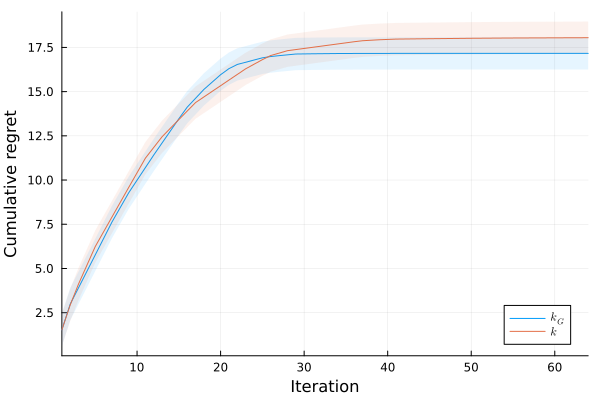

"/home/theo/documents/ucl/bayesopt_under_invariance/ucb_β=5.5_cumulative_regret.png"

In [14]:
using LaTeXStrings

figure = plot(legend=:topright, xlabel="Iteration", ylabel="Cumulative regret")
h5open("$(label)_results.h5", "r") do file
    for gp_builder in [build_permutationinvariantmatern52_gp, build_matern52_gp]
        gp_builder_group = file[string(gp_builder)]

        if gp_builder == build_permutationinvariantmatern52_gp
            trace_label = L"$k_G$"
        else
            trace_label = L"$k$"
        end

        simple_regret = zeros(n_repeats, n_iterations)
        for i in 1:n_repeats
            repeat_group = gp_builder_group[string(i)]
            observed_y = read_dataset(repeat_group, "observed_y")

            for j in 1:n_iterations
                simple_regret[i, j] = y_opt - maximum(observed_y[1:j])
            end
        end

        # Convert to cumulative regret
        cumulative_regret = cumsum(simple_regret, dims=2)

        # Plot the simple regret with error bars
        plot!(
            1:n_iterations,
            vec(mean(cumulative_regret, dims=1)),
            ribbon=sqrt.(var(cumulative_regret, dims=1)),
            fillalpha=0.1,
            label=trace_label,
            xlabel="Iteration",
            ylabel="Cumulative regret",
            legend=:bottomright,
            xlims=(1, n_iterations),
        )
    end
end

display(figure)

# Save the figure
savefig(figure, "$(label)_cumulative_regret.png")